# Bio-climate coupling with restarting biology

Simulates Bio-climate coupling with restarting biology if there is a abiotic heating of the atmosphere

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import time
from IPython.utils import io
import xarray as xr
import gc

# Loading modules
from Main_evolution_function_RK import *
from EXO_K_wo_ocean import *
from Constants import *
from Functions2 import *
from Functions import *
from Bio_model import *
from Photochem import *



%matplotlib notebook
plt.rcParams["figure.figsize"] = (7, 4)
mpl.rcParams['text.usetex'] = False
from cycler import cycler

colors = cycler('color', [plt.cm.inferno(i) for i in np.linspace(0.1, 1, 5)])
plt.rc('axes', axisbelow=True, grid=True, labelcolor='dimgray', labelweight='bold', prop_cycle=colors)
plt.rc('grid', linestyle='solid')
plt.rc('xtick', direction='in', color='dimgray')
plt.rc('ytick', direction='in', color='dimgray')
plt.rc('lines', linewidth=1.5)

In [2]:
# INTERPOLATION FOR INITIAL VALUES (FOR THE BIOLOGICAL INTEGRATION)

import pandas as pd
import numpy as np
from scipy.interpolate import LinearNDInterpolator

# Load the CSV file
df = pd.read_csv("Grid_values_ini.csv")

points = df[['P', 'T', 'fG']].values  # Input variables: Pressure, Temperature, and gas fraction
NCeq = df['NCeq'].values              # Output variables: equilibrium and concentrations
cH = df['cH'].values
cC = df['cC'].values
cG = df['cG'].values
cN = df['cN'].values

# Create interpolators for each output variable
interp_NCeq = LinearNDInterpolator(points, NCeq)
interp_cH = LinearNDInterpolator(points, cH)
interp_cC = LinearNDInterpolator(points, cC)
interp_cG = LinearNDInterpolator(points, cG)
interp_cN = LinearNDInterpolator(points, cN)

# Interpolation function to retrieve interpolated concentrations for given P, T, fG
def interp_conc(P, T, fG):
    pt = np.array([[P, T, fG]])
    return {
        'NC': interp_NCeq(pt)[0],
        'cH': interp_cH(pt)[0],
        'cC': interp_cC(pt)[0],
        'cG': interp_cG(pt)[0],
        'cN': interp_cN(pt)[0]
    }

In [3]:
# FUNCTION TO COUPLE BIOLOGY AND CLIMATE

def coupling(CH4_threshold_list, Teq, t0, NC0, cH0, cC0, cG0, cN0, fH0, fC0, fG0, fN0, Psurf, ntotgasfinal):
    """
    Simulates the coupling between biological evolution and atmospheric/climate dynamics 
    under varying methane thresholds. This function iteratively runs a bio-climate system 
    model and atmospheric equilibrium model until a surface temperature drops below 271 K. 
    After each iteration, it updates the atmospheric and biological state.

    The function returns the time evolution of multiple variables, including atmospheric 
    composition, surface pressure, and biological productivity.

    Parameters:
    ----------
    CH4_threshold_list : list of floats
        List of methane fraction thresholds to use for each successive system evolution run.
    
    Teq : float
        Initial surface equilibrium temperature (K).
    
    t0 : float
        Initial simulation time (in days).
    
    NC0 : float
        Initial concentration of a methanogens (cells/L).
    
    cH0, cC0, cG0, cN0 : floats
        Initial concentrations of H₂, CO₂, CH₄, and N₂ in water (mol/L).
    
    fH0, fC0, fG0, fN0 : floats
        Initial atmospheric molar fractions of H₂, CO₂, CH₄, and N₂.
    
    Psurf : float
        Initial surface atmospheric pressure (Pa).
    
    ntotgasfinal : float
        Initial total number of atmospheric moles.

    Returns:
    -------
    list
        A list containing the time evolution of key variables:
        [0] big_time_list       : Global simulation time (atmospheric and concentration time steps) (days)
        [1] big_timep_list      : Global simulation time (flux and pressure time steps) (days)
        [2] big_h2_atm_list     : Atmospheric H₂ matter quantity over time (mol)
        [3] big_co2_atm_list    : Atmospheric CO₂ matter quantity over time (mol)
        [4] big_ch4_atm_list    : Atmospheric CH₄ matter quantity over time (mol)
        [5] big_n2_atm_list     : Atmospheric N₂ matter quantity over time (mol)
        [6] big_h2_wat_list     : Water H₂ matter quantity over time (mol)
        [7] big_ch4_wat_list    : Water CH₄ matter quantity over time (mol)
        [8] big_co2_wat_list    : Water CO₂ matter quantity over time (mol)
        [9] big_n2_wat_list     : Water N₂ matter quantity over time (mol)
        [10] big_pressure_list  : Surface pressure over time (Pa)
        [11] big_NC_list        : Cells concentration (cells/L) over time
        [12] big_X_list         : Biological matter over time
        [13] t_list             : Cumulative time after each CH₄ threshold iteration
        [14] Teq_list           : Surface temperature at each iteration
        [15] ifinal             : Index of the final CH₄ threshold used before termination
    """

    # Start timing the execution
    t1 = time.time()

    # Initialize lists to store results per iteration
    Teq_list = [Teq]
    t_list = [t0]
    bio_all = []
    atmo_all = []
    times_all = []
    press_all = []
    medium_all = []
    timesp_all = []
    X_all = []

    # Initialize concentrations and atmospheric fractions
    cH, cC, cG, cN = cH0, cC0, cG0, cN0
    fH, fC, fG, fN = fH0, fC0, fG0, fN0

    # Dictionary of initial concentrations for use in the model
    dico_ini = {'NC': NC0,
                'cH': cH0,
                'cC': cC0,
                'cG': cG0,
                'cN': cN0}

    # Derive biological traits based on temperature
    Traits = ReturnTraits(Teq, Par, 1)
    X0 = 2 * Traits[3]

    T_surf = Teq

    # Main loop over methane thresholds
    if Teq > 271:
        for i in range(len(CH4_threshold_list)):
            print('=================================== Iteration', i + 1, '/', len(CH4_threshold_list), '===============================================')

            fgt = float(CH4_threshold_list[i])

            # Run biological and atmospheric simulation with given CH₄ threshold
            Bio, Medium, Atmo, t, flux, flux_times, Pression = system_evolution_RK(
                Psurf, Teq, 550 * Mars_surface, 1 / 11 * fraction_ocean, 1e5, Mars_surface,
                ntotgasfinal, X0, CH4_frac_threshold=fgt,
                focean=fraction_ocean, Atm_compo=(fH, fC, fG, fN),
                concentration_ini=(dico_ini['cH'], dico_ini['cC'], dico_ini['cG'], dico_ini['cN']),
                NC_0=dico_ini['NC'], rtol=1e-7, atol=1e-20,
                methode='LSODA', N=int(1e4), firststep=None, minstep=np.nan)

            ifinal = i
            # Store results for later concatenation
            atmo_all.append(Atmo)
            times_all.append(t)
            bio_all.append(Bio[0])
            X_all.append(Bio[1])
            press_all.append(Pression)
            medium_all.append(Medium)
            timesp_all.append(flux_times)

            # Update system state for next iteration
            tfinal = t[-1]
            ntotgasfinal = np.sum(Atmo[:, -1])
            fG = Atmo[2][-1] / ntotgasfinal
            fC = Atmo[1][-1] / ntotgasfinal
            fH = Atmo[0][-1] / ntotgasfinal
            fN = Atmo[3][-1] / ntotgasfinal
            X0 = Bio[1][-1]
            cG = Medium[2][-1] / (Mars_surface * 550 * 1e3)
            cC = Medium[1][-1] / (Mars_surface * 550 * 1e3)
            cH = Medium[0][-1] / (Mars_surface * 550 * 1e3)
            cN = Medium[3][-1] / (Mars_surface * 550 * 1e3)

            Psurf = Pression[-1]
            t_list.append(t_list[-1] + tfinal)

            print('fG', round(fG, 6))
            print('Calculating atmospheric equilibrium...')

            CH4_threshold = CH4_threshold_list[i]

            # Compute atmospheric equilibrium using radiative-convective model
            with io.capture_output() as _:
                evol_mars = defining_atm(fH, fG, fN, Ptop, Psurf, T_surf, acceleration=None)
                evol_mars.equilibrate(Fnet_tolerance=0.1, verbose=False)

            teq, Teq, T_profile, P_profile = equilibrium_state_values(evol_mars)
            T_surf = Teq

            print('Atmospheric equilibrium : P_surf =', round(P_profile[-1] / 1e5, 5), 'bar', ' and T_surf = ', round(Teq, 2), 'K')
            print("Actual time in years", round(t_list[-1] / (365.25), 2))

            del evol_mars
            gc.collect()

            NC = Bio[0][-1]

            # Interpolate new biological initial values for the next iteration
            dico_ini = interp_conc(Psurf, Teq, fG)
            Teq_list.append(Teq)

            if Teq < 271:
                break

    # Concatenate all time-series outputs from each iteration
    print("Concatenation....")
    big_time_list = []
    big_timep_list = []
    big_ch4_atm_list = []
    big_n2_atm_list = []
    big_h2_atm_list = []
    big_co2_atm_list = []
    big_ch4_wat_list = []
    big_n2_wat_list = []
    big_h2_wat_list = []
    big_co2_wat_list = []
    big_pressure_list = []
    big_NC_list = []
    big_X_list = []

    for i in range(len(t_list) - 1):
        ttim = np.array(times_all[i]) + t_list[i]
        ttim2 = np.array(timesp_all[i]) + t_list[i]
        big_time_list = np.concatenate([big_time_list, ttim])
        big_timep_list = np.concatenate([big_timep_list, ttim2])
        big_ch4_atm_list = np.concatenate([big_ch4_atm_list, atmo_all[i][2]])
        big_n2_atm_list = np.concatenate([big_n2_atm_list, atmo_all[i][3]])
        big_h2_atm_list = np.concatenate([big_h2_atm_list, atmo_all[i][0]])
        big_co2_atm_list = np.concatenate([big_co2_atm_list, atmo_all[i][1]])
        big_ch4_wat_list = np.concatenate([big_ch4_wat_list, medium_all[i][2]])
        big_n2_wat_list = np.concatenate([big_n2_wat_list, medium_all[i][3]])
        big_h2_wat_list = np.concatenate([big_h2_wat_list, medium_all[i][0]])
        big_co2_wat_list = np.concatenate([big_co2_wat_list, medium_all[i][1]])
        big_pressure_list = np.concatenate([big_pressure_list, press_all[i]])
        big_NC_list = np.concatenate([big_NC_list, bio_all[i]])
        big_X_list = np.concatenate([big_X_list, X_all[i]])

    print("End of concatenation")
    print("Coupling finished in :", round(time.time() - t1, 0), "s")

    return [big_time_list, big_timep_list, big_h2_atm_list, big_co2_atm_list, big_ch4_atm_list, big_n2_atm_list,
            big_h2_wat_list, big_ch4_wat_list, big_co2_wat_list, big_n2_wat_list, big_pressure_list, big_NC_list, big_X_list,
            t_list, Teq_list, ifinal]

            

In [4]:
from alive_progress import alive_bar
import numpy as np

def atmo_evol(ntotgas0, fH0, fC0, fG0, fN0, P0, fG_threshold, tmax=365.25*200):
    """
    Simulates the evolution of a planetary atmosphere subject to hydrogen (H₂) and methane (CH₄) fluxes
    over time due to escape and photodissociation.

    The function stops the simulation once the atmospheric CH₄ fraction drops below a specified threshold.

    Parameters:
    -----------
    ntotgas0 : float
        Initial total number of atmospheric molecules (mol).
    
    fH0, fC0, fG0, fN0 : floats
        Initial molar fractions of H₂, CO₂, CH₄, and N₂ in the atmosphere, respectively.
    
    P0 : float
        Initial surface pressure of the atmosphere (Pa).
    
    fG_threshold : float
        Threshold value of CH₄ molar fraction that stops the simulation.
    
    tmax : float, optional
        Maximum simulation time in days (default is 200 years).

    Returns:
    --------
    tuple of np.ndarray
        Contains the following arrays:
        [0] time          : Time points (days)
        [1] natmH_list    : Atmospheric quantity of H₂ over time 
        [2] natmC_list    : Atmospheric quantity of CO₂ over time (constant)
        [3] natmG_list    : Atmospheric quantity of CH₄ over time
        [4] natmN_list    : Atmospheric quantity of N₂ over time (constant)
        [5] press_list    : Surface pressure evolution over time (Pa)
    """

    # Initialize time and atmospheric quantities
    time = [0]
    natmH_list = [fH0 * ntotgas0]
    natmC_list = [fC0 * ntotgas0]
    natmG_list = [fG0 * ntotgas0]
    natmN_list = [fN0 * ntotgas0]
    press_list = [P0]

    # Initialize molar fractions
    fH, fC, fG, fN = fH0, fC0, fG0, fN0

    # Time step (in days) and scaling factor for escape rates
    dt = 100  # days
    factorB = dt * 86400 * Mars_surface * 1e4 / Av  # Converts escape rates to molecule counts

    # Number of iterations
    n_steps = int(tmax // dt)

    # Progress bar to visualize simulation progress
    with alive_bar(n_steps, title='Simulating atmosphere') as bar:
        for _ in range(n_steps):
            # Compute H₂ and CH₄ losses (photodissociation + escape)
            dH_atm = FH2_func(fH * press_list[-1] * 1e-5, fG * press_list[-1] * 1e-5) * factorB
            dG_atm = FCH4_func(fH * press_list[-1] * 1e-5, fG * press_list[-1] * 1e-5) * factorB

            # Update atmospheric quantities
            natmH_list.append(natmH_list[-1] + dH_atm)
            natmG_list.append(natmG_list[-1] + dG_atm)
            natmC_list.append(fC0 * ntotgas0)  # Assumed constant
            natmN_list.append(fN0 * ntotgas0)  # Assumed constant

            # Update time
            time.append(time[-1] + dt)

            # Recompute total atmospheric mass and updated molar fractions
            ntot = natmH_list[-1] + natmC_list[-1] + natmG_list[-1] + natmN_list[-1]
            fH = natmH_list[-1] / ntot
            fG = natmG_list[-1] / ntot

            # Update surface pressure
            press_list.append(P0 * ntot / ntotgas0)

            # Update progress bar
            bar()

            # Stop if CH₄ fraction falls below the threshold
            if fG <= fG_threshold:
                print("CH4 threshold reached:", round(fG, 6), 'at t =', time[-1]/365.25, 'years')
                break

    return (
        np.array(time),
        np.array(natmH_list),
        np.array(natmC_list),
        np.array(natmG_list),
        np.array(natmN_list),
        np.array(press_list)
    )

In [5]:
# PREBIOTIC ATMOSPHERIC EQUILIBRIUM

print("Volume of the ocean :",format(550*Mars_surface,".2e"),"m^3")
print("Ratio of the ocean over Mars surface :",round(fraction_ocean,4))

print('=================================== First equilibrium =================================================')
print('Calculating atmospheric equilibrium...')

T_surf = 300
Ptop = 1.0 #Pa
Psurf = 2e5 #Pa
fH = 0.15
fG = 0
fN = 0.04
fC = 1 - fN - fG - fH

with io.capture_output() as _:
    evol_mars = defining_atm(fH, fG, fN, Ptop, Psurf, T_surf,acceleration=None)
    evol_mars.equilibrate(Fnet_tolerance=0.1,  verbose=False)

teq,Teq,T_profile,P_profile = equilibrium_state_values(evol_mars)
del evol_mars
gc.collect()

print('Atmospheric equilibrium : P_surf =',round(P_profile[-1]/1e5,5),'bar',' and T_surf = ',round(Teq,2),'K')

Z,dZ = compute_altitudes(P_profile, T_profile, 0.03706)
ntotgas0 = atm_matter_quantity(P_profile, T_profile,dZ,0.03706, Mars_surface)

Volume of the ocean : 7.98e+16 m^3
Ratio of the ocean over Mars surface : 0.2985
=================================== First equilibrium =================================================
Calculating atmospheric equilibrium...
Atmospheric equilibrium : P_surf = 2.0 bar  and T_surf =  302.28 K


In [6]:
# CREATING BIG LISTS TO STORE ALL THE DATA

LIST_WAT_H1 = np.array([])
LIST_WAT_C1 = np.array([])
LIST_WAT_G1 = np.array([])
LIST_WAT_N1 = np.array([])
LIST_ATM_H1 = np.array([])
LIST_ATM_C1 = np.array([])
LIST_ATM_G1 = np.array([])
LIST_ATM_N1 = np.array([])
LIST_NC1    = np.array([])
LIST_X1     = np.array([])
LIST_T1     = np.array([])
LIST_TP1    = np.array([])
LIST_PRESS1 = np.array([])

LISTIND_TIME1 = np.array([])
LISTIND_TEMP1 = np.array([])

In [7]:
# COUPLING

from pyfiglet import Figlet 
f = Figlet(font='standard')
print(f.renderText('Main coupling'))

finish_bio = False
counter = 0

niter1 = 10
niter2 = 50
CH4_threshold_list =  np.concatenate([10**np.linspace(-7,-3,niter1),np.linspace(1.001e-3,0.05,niter2)])

Teq_ini = Teq
t_ini   = 0
NC_ini  = 1e4
cH_ini  = 0
cC_ini  = 0
cG_ini  = 0
cN_ini  = 0
fH0,fC0,fG0,fN0 = 0.15,0.81,0.0,0.04
P0 = Psurf

Y = coupling(CH4_threshold_list,Teq_ini,t_ini,NC_ini,cH_ini,cC_ini,cG_ini,cN_ini,fH0,fC0,fG0,fN0,P0,ntotgas0)

big_time_list     = Y[0]
big_timep_list    = Y[1]
big_h2_atm_list   = Y[2]
big_co2_atm_list  = Y[3]
big_ch4_atm_list  = Y[4]
big_n2_atm_list   = Y[5]
big_h2_wat_list   = Y[6]
big_ch4_wat_list  = Y[7]
big_co2_wat_list  = Y[8]
big_n2_wat_list   = Y[9]
big_pressure_list = Y[10]
big_NC_list       = Y[11]
big_X_list        = Y[12]
t_list            = Y[13]
Teq_list          = Y[14]
index             = Y[15]

LIST_WAT_H1 = np.concatenate((LIST_WAT_H1, Y[6]))
LIST_WAT_C1 = np.concatenate((LIST_WAT_C1, Y[8]))
LIST_WAT_G1 = np.concatenate((LIST_WAT_G1, Y[7]))
LIST_WAT_N1 = np.concatenate((LIST_WAT_N1, Y[9]))
LIST_ATM_H1 = np.concatenate((LIST_ATM_H1, Y[2]))
LIST_ATM_C1 = np.concatenate((LIST_ATM_C1, Y[3]))
LIST_ATM_G1 = np.concatenate((LIST_ATM_G1, Y[4]))
LIST_ATM_N1 = np.concatenate((LIST_ATM_N1, Y[5]))
LIST_NC1    = np.concatenate((LIST_NC1,    Y[11]))
LIST_X1     = np.concatenate((LIST_X1,     Y[12]))
LIST_T1     = np.concatenate((LIST_T1,     Y[0]))
LIST_TP1    = np.concatenate((LIST_TP1,    Y[1]))
LIST_PRESS1 = np.concatenate((LIST_PRESS1, Y[10]))
LISTIND_TIME1 = np.concatenate((LISTIND_TIME1, Y[13]))
LISTIND_TEMP1 = np.concatenate((LISTIND_TEMP1, Y[14]))

fGmax = CH4_threshold_list[index-1]
fGmin = CH4_threshold_list[index]

 __  __       _                               _ _             
|  \/  | __ _(_)_ __     ___ ___  _   _ _ __ | (_)_ __   __ _ 
| |\/| |/ _` | | '_ \   / __/ _ \| | | | '_ \| | | '_ \ / _` |
| |  | | (_| | | | | | | (_| (_) | |_| | |_) | | | | | | (_| |
|_|  |_|\__,_|_|_| |_|  \___\___/ \__,_| .__/|_|_|_| |_|\__, |
                                       |_|              |___/ 

=================================== Iteration 1 / 60 ===============================================
RK3
Integration [!                                       ] (!) 3/10000 [0%] in 1.2s 
fG 0.0
Calculating atmospheric equilibrium...
Atmospheric equilibrium : P_surf = 1.99757 bar  and T_surf =  302.57 K
Actual time in years 0.05
=================================== Iteration 2 / 60 ===============================================
RK3
Integration [!                                       ] (!) 1/10000 [0%] in 0.1s 
fG 0.0
Calculating atmospheric equilibrium...
Atmospheric equilibrium : P_surf = 1.99756 bar  and T_surf =

In [62]:
LIST_WAT_H = LIST_WAT_H1 
LIST_WAT_C = LIST_WAT_C1
LIST_WAT_G = LIST_WAT_G1
LIST_WAT_N = LIST_WAT_N1
LIST_ATM_H = LIST_ATM_H1
LIST_ATM_C = LIST_ATM_C1
LIST_ATM_G = LIST_ATM_G1
LIST_ATM_N = LIST_ATM_N1 
LIST_NC    = LIST_NC1
LIST_X     = LIST_X1
LIST_T     = LIST_T1
LIST_TP    = LIST_TP1 
LIST_PRESS = LIST_PRESS1

LISTIND_TIME = LISTIND_TIME1
LISTIND_TEMP = LISTIND_TEMP1

tabiobegin_list = []
tabioend_list = []

In [63]:
finish_bio = False

f = Figlet(font='standard',width=100)
print(f.renderText('Restart of biological processes'))

if LISTIND_TEMP[-1] > 271:
    print("Temperature is always over 271K : check Main coupling")
    finish_bio = True
    
counter = 0
nevol=3
while finish_bio == False:
    
    tabiobegin_list.append(LISTIND_TIME[-1])
    
    counter += 1
    if counter >= nevol:
        finish_bio = True

    print("################# Abiotic evolution ",counter, '/', nevol, "###################################################")
        
    ntotgas = LIST_ATM_H[-1] + LIST_ATM_C[-1] + LIST_ATM_G[-1] + LIST_ATM_N[-1]
    fH = LIST_ATM_H[-1] / ntotgas
    fC = LIST_ATM_C[-1] / ntotgas
    fG = LIST_ATM_G[-1] / ntotgas
    fN = LIST_ATM_N[-1] / ntotgas
    P2  = LIST_PRESS[-1]
    # fG_threshold2 = LIST_ATM_G[-index] / (LIST_ATM_H[-index] + LIST_ATM_C[-index] + LIST_ATM_G[-index] + LIST_ATM_N[-index])
    fG_threshold2 = fGmax*0

    print("Abiotic evolution of the atmosphere...")
    W = atmo_evol(ntotgas,fH,fC,fG,fH,P2,fG_threshold2,tmax=365.25*30e3)
    
    LIST_WAT_H = np.concatenate((LIST_WAT_H, np.array([LIST_WAT_H[-1] for _ in range(len(W[0]))])))
    LIST_WAT_C = np.concatenate((LIST_WAT_C, np.array([LIST_WAT_C[-1] for _ in range(len(W[0]))])))
    LIST_WAT_G = np.concatenate((LIST_WAT_G, np.array([LIST_WAT_G[-1] for _ in range(len(W[0]))])))
    LIST_WAT_N = np.concatenate((LIST_WAT_N, np.array([LIST_WAT_N[-1] for _ in range(len(W[0]))])))
    LIST_ATM_H = np.concatenate((LIST_ATM_H, W[1]))
    LIST_ATM_C = np.concatenate((LIST_ATM_C, W[2]))
    LIST_ATM_G = np.concatenate((LIST_ATM_G, W[3]))
    LIST_ATM_N = np.concatenate((LIST_ATM_N, W[4]))
    LIST_NC    = np.concatenate((LIST_NC,    np.array([0 for _ in range(len(W[0]))])))
    LIST_X     = np.concatenate((LIST_X,     np.array([0 for _ in range(len(W[0]))])))
    LIST_T     = np.concatenate((LIST_T,     W[0]+LIST_T[-1]))
    LIST_TP    = np.concatenate((LIST_TP,    W[0]+LIST_TP[-1]))
    LIST_PRESS = np.concatenate((LIST_PRESS, W[5]))
    
    ntotgas = LIST_ATM_H[-1] + LIST_ATM_C[-1] + LIST_ATM_G[-1] + LIST_ATM_N[-1]
    fH = LIST_ATM_H[-1] / ntotgas
    fC = LIST_ATM_C[-1] / ntotgas
    fG = LIST_ATM_G[-1] / ntotgas
    fN = LIST_ATM_N[-1] / ntotgas
    print("Calculating atmospheric equilibrium...")
    with io.capture_output() as _:
        evol_mars = defining_atm(fH, fG, fN, Ptop, LIST_PRESS[-1],LISTIND_TEMP[-1],acceleration=None)
        evol_mars.equilibrate(Fnet_tolerance=0.1,  verbose=False)

    teq,Teq,T_profile,P_profile = equilibrium_state_values(evol_mars)
    del evol_mars
    gc.collect()
    print('Atmospheric equilibrium : P_surf =',round(P_profile[-1]/1e5,5),'bar',' and T_surf = ',round(Teq,2),'K')
    LISTIND_TIME = np.concatenate((LISTIND_TIME, [W[0][-1]+LISTIND_TIME[-1]]))
    LISTIND_TEMP = np.concatenate((LISTIND_TEMP, [Teq]))
    tabioend_list.append(LISTIND_TIME[-1])
    if Teq < 271:
        print("Temperature stays under 271K --> end of the simulation")
        break
    
    niter =10
    fG1 = min(fG,fGmin,fGmax)
    fG2 = max(fG,fGmin,fGmax) 
    CH4_threshold_list =  np.linspace(fG,fG+0.01,niter)
    
    print('fGmin',fGmin)
    print('fGmax',fGmax)
    print('threshol list',CH4_threshold_list)
    
    Teq_ini = Teq
    T_surf = Teq
    t_ini   = LIST_T[-1]
    NC_ini  = 1e4
    cH_ini  = LIST_WAT_H[-1] / (550e3 * Mars_surface)
    cC_ini  = LIST_WAT_C[-1] / (550e3 * Mars_surface)
    cG_ini  = LIST_WAT_G[-1] / (550e3 * Mars_surface)
    cN_ini  = LIST_WAT_N[-1] / (550e3 * Mars_surface)
    print('t_ini',t_ini)
    Y = coupling(CH4_threshold_list,Teq_ini,t_ini,NC_ini,cH_ini,cN_ini,cG_ini,cH_ini,fH,fC,fG,fN,LIST_PRESS[-1],ntotgas)

    index = Y[15]

    LIST_WAT_H = np.concatenate((LIST_WAT_H, Y[6]))
    LIST_WAT_C = np.concatenate((LIST_WAT_C, Y[8]))
    LIST_WAT_G = np.concatenate((LIST_WAT_G, Y[7]))
    LIST_WAT_N = np.concatenate((LIST_WAT_N, Y[9]))
    LIST_ATM_H = np.concatenate((LIST_ATM_H, Y[2]))
    LIST_ATM_C = np.concatenate((LIST_ATM_C, Y[3]))
    LIST_ATM_G = np.concatenate((LIST_ATM_G, Y[4]))
    LIST_ATM_N = np.concatenate((LIST_ATM_N, Y[5]))
    LIST_NC    = np.concatenate((LIST_NC,    Y[11]))
    LIST_X     = np.concatenate((LIST_X,     Y[12]))
    LIST_T     = np.concatenate((LIST_T,     Y[0]))
    LIST_TP    = np.concatenate((LIST_TP,    Y[1]))
    LIST_PRESS = np.concatenate((LIST_PRESS, Y[10]))
    LISTIND_TIME = np.concatenate((LISTIND_TIME, Y[13]))
    LISTIND_TEMP = np.concatenate((LISTIND_TEMP, Y[14]))
    
    if LISTIND_TEMP[-1] > 271:
        print("End of simulation : cause --> impossible to go below 271K")
        finish_bio = True

 ____           _             _            __   _     _       _             _           _ 
|  _ \ ___  ___| |_ __ _ _ __| |_    ___  / _| | |__ (_) ___ | | ___   __ _(_) ___ __ _| |
| |_) / _ \/ __| __/ _` | '__| __|  / _ \| |_  | '_ \| |/ _ \| |/ _ \ / _` | |/ __/ _` | |
|  _ <  __/\__ \ || (_| | |  | |_  | (_) |  _| | |_) | | (_) | | (_) | (_| | | (_| (_| | |
|_| \_\___||___/\__\__,_|_|   \__|  \___/|_|   |_.__/|_|\___/|_|\___/ \__, |_|\___\__,_|_|
                                                                      |___/               
                                             
 _ __  _ __ ___   ___ ___  ___ ___  ___  ___ 
| '_ \| '__/ _ \ / __/ _ \/ __/ __|/ _ \/ __|
| |_) | | | (_) | (_|  __/\__ \__ \  __/\__ \
| .__/|_|  \___/ \___\___||___/___/\___||___/
|_|                                          

################# Abiotic evolution  1 / 3 ###################################################
Abiotic evolution of the atmosphere...
Simulating atmosphere [====================

### Plotting evolutions over time

In [64]:
t_list_years = (LIST_T/365.25)
tp_list_years = (LIST_TP/365.25)
t_listind_years = (LISTIND_TIME/365.25)

<IPython.core.display.Javascript object>


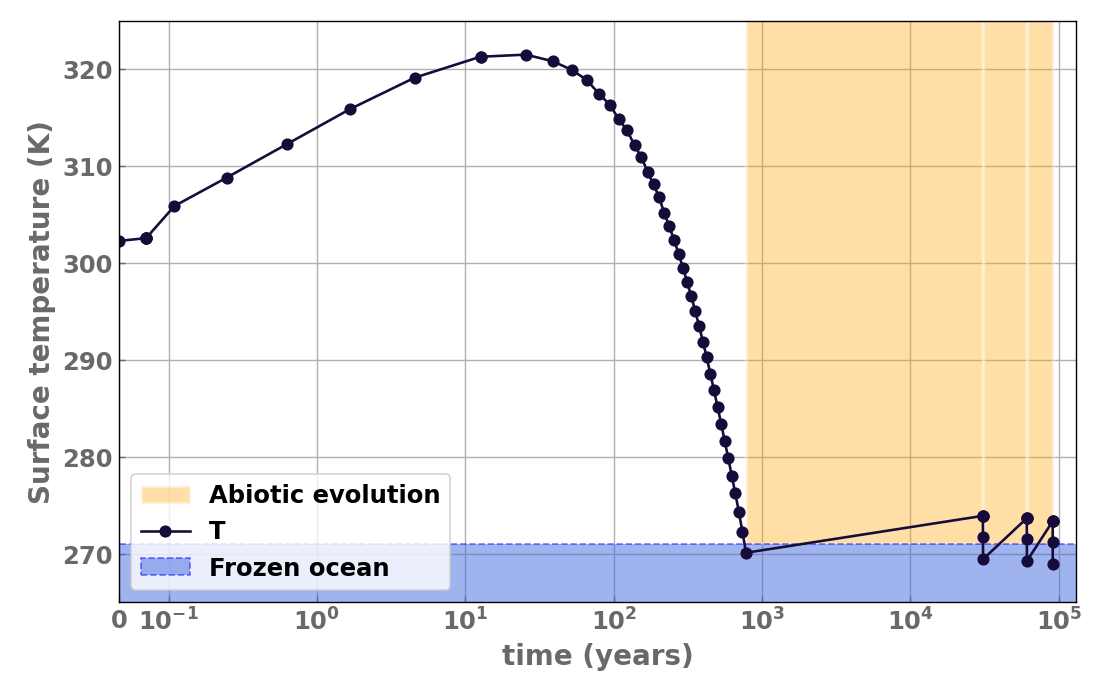

In [68]:
fig, ax = plt.subplots()

for m in range(len(tabiobegin_list)):
    x1 = tabiobegin_list[m] / 365.25
    x2 = tabioend_list[m] / 365.25
    y1 = 271
    y2 = 1000
    plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='orange', alpha=0.35,edgecolor='white',linewidth=2,
            label='Abiotic evolution' if m == 0 else None)

test = [k for k in range(17)]
ax.plot(t_listind_years , LISTIND_TEMP, label='T',marker='o')
# ax.scatter(t_list_years , Teq_list)

# ax.legend(fontsize=14, frameon=True)
# for text in ax.get_legend().get_texts():
#     text.set_weight('bold')
ax.set_ylabel(f'Surface temperature (K)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')

x = np.linspace(-1000, 140000, 100)
y1 = np.full_like(x, 0) 
y2 = np.full_like(x, 271) 

ax.fill_between(x, y1, y2, color='royalblue', alpha=0.5, label='Frozen ocean',linestyle='--',edgecolor='blue',linewidth=1)

ax.set_ylim(265,325)
ax.set_xlim(0,130e3)

ax.set_xscale('symlog',linthresh=1e-1,linscale=0.3)


fig.set_figheight(5)
fig.set_figwidth(8)


    
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')  
    
ax.legend(fontsize=14, frameon=True,loc='lower left')
for text in ax.get_legend().get_texts():
    text.set_weight('bold')    

fig.tight_layout()
# plt.savefig("001_1D_surface_temperature.png",dpi=300,bbox_inches='tight')

<IPython.core.display.Javascript object>


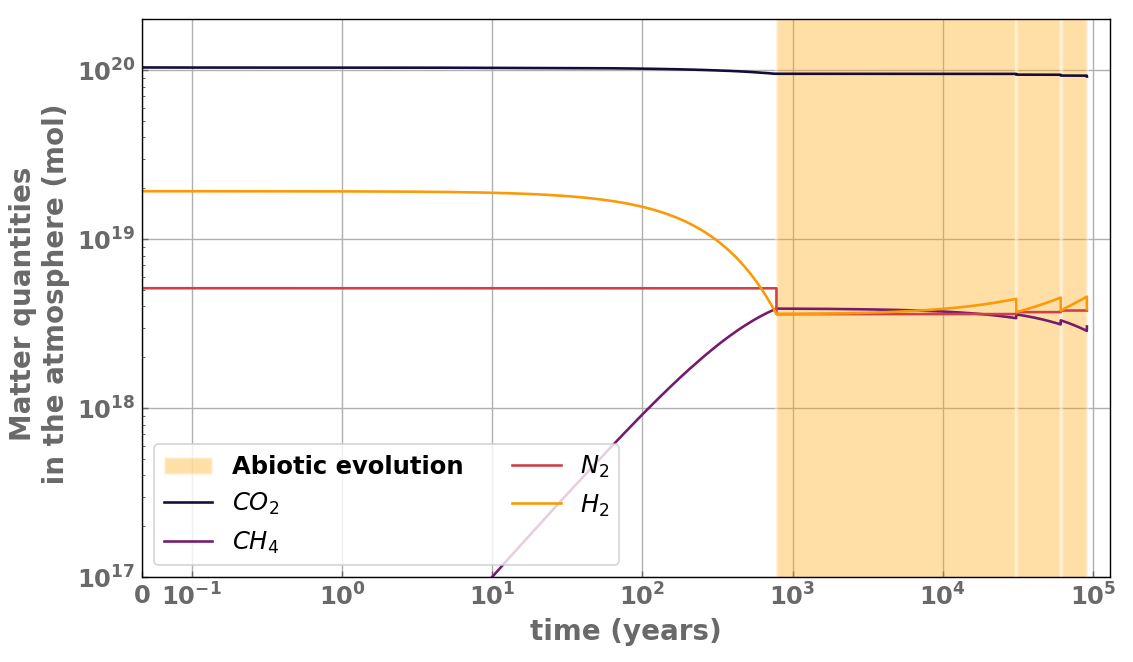

In [73]:
fig, ax = plt.subplots(1, 1)

for m in range(len(tabiobegin_list)):
    x1 = tabiobegin_list[m] / 365.25
    x2 = tabioend_list[m] / 365.25
    y1 = 0
    y2 = 1e50
    plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='orange', alpha=0.35,edgecolor='white',linewidth=2,
            label='Abiotic evolution' if m == 0 else None)

ax.plot(t_list_years, LIST_ATM_C, label=r'${CO_2}$')
ax.plot(t_list_years , LIST_ATM_G, label=r'${CH_4}$')
ax.plot(t_list_years, LIST_ATM_N, label=r'${N_2}$')
ax.plot(t_list_years , LIST_ATM_H, label=r'${H_2}$')


ax.legend(fontsize=14, frameon=True,loc='lower left',ncol=2)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'Matter quantities \n in the atmosphere (mol)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('log')

ax.set_ylim(1e17,2e20)
ax.set_xlim(0,130e3)
ax.set_xscale('symlog',linthresh=1e-1,linscale=0.3)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
# plt.savefig("001_1D_atmo_nX.png",dpi=300,bbox_inches='tight')

<IPython.core.display.Javascript object>


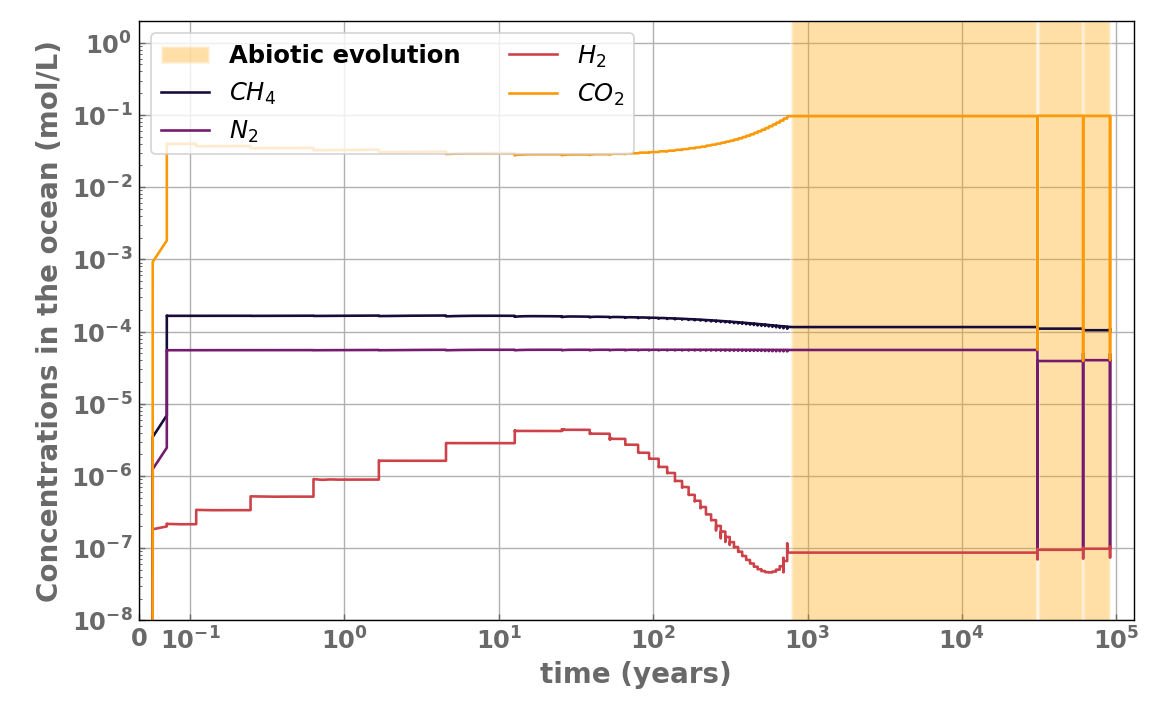

In [77]:
fig, ax = plt.subplots(1, 1)

for m in range(len(tabiobegin_list)):
    x1 = tabiobegin_list[m] / 365.25
    x2 = tabioend_list[m] / 365.25
    y1 = 0
    y2 = 1e50
    plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='orange', alpha=0.35,edgecolor='white',linewidth=2,
            label='Abiotic evolution' if m == 0 else None)

# ax.plot(big_time_list_years[::100] , np.convolve(np.array(big_ch4_wat_list)/(550*1e3*Mars_surface), np.ones(100000)/100000, mode='same')[::100], label=r'${CH_4}$')
ax.plot(t_list_years , LIST_WAT_G/(550*1e3*Mars_surface), label=r'${CH_4}$')
ax.plot(t_list_years , LIST_WAT_N/(550*1e3*Mars_surface), label=r'${N_2}$')
ax.plot(t_list_years , LIST_WAT_H/(550*1e3*Mars_surface), label=r'${H_2}$')
ax.plot(t_list_years , LIST_WAT_C/(550*1e3*Mars_surface), label=r'${CO_2}$')

ax.legend(fontsize=14, frameon=True,loc='upper left',ncol=2)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'Concentrations in the ocean (mol/L)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('log')

ax.set_ylim(1e-8,2)
ax.set_xlim(0,130e3)
ax.set_xscale('symlog',linthresh=1e-1,linscale=0.3)


ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
    
fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
# plt.savefig("001_1D_ocean_CX.png",dpi=300,bbox_inches='tight')

<IPython.core.display.Javascript object>


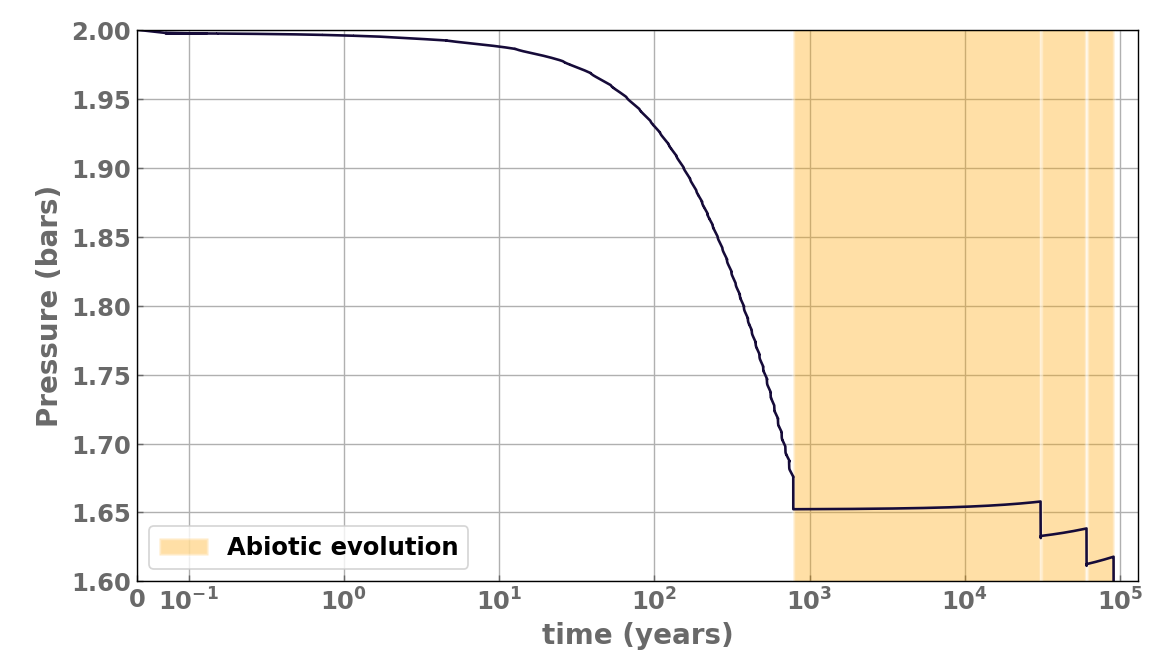

In [81]:
fig, ax = plt.subplots(1, 1)

for m in range(len(tabiobegin_list)):
    x1 = tabiobegin_list[m] / 365.25
    x2 = tabioend_list[m] / 365.25
    y1 = 0
    y2 = 1e50
    plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='orange', alpha=0.35,edgecolor='white',linewidth=2,
            label='Abiotic evolution' if m == 0 else None)

ax.plot(tp_list_years , LIST_PRESS/1e5)

ax.legend(fontsize=14, frameon=True,loc='lower left')
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'Pressure (bars)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
# ax.set_yscale('log')




ax.set_ylim(1.6,2)
ax.set_xlim(0,130e3)
ax.set_xscale('symlog',linthresh=1e-1,linscale=0.3)

ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
# plt.savefig("001_1D_Pressure.png",dpi=300,bbox_inches='tight')

fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()

<IPython.core.display.Javascript object>


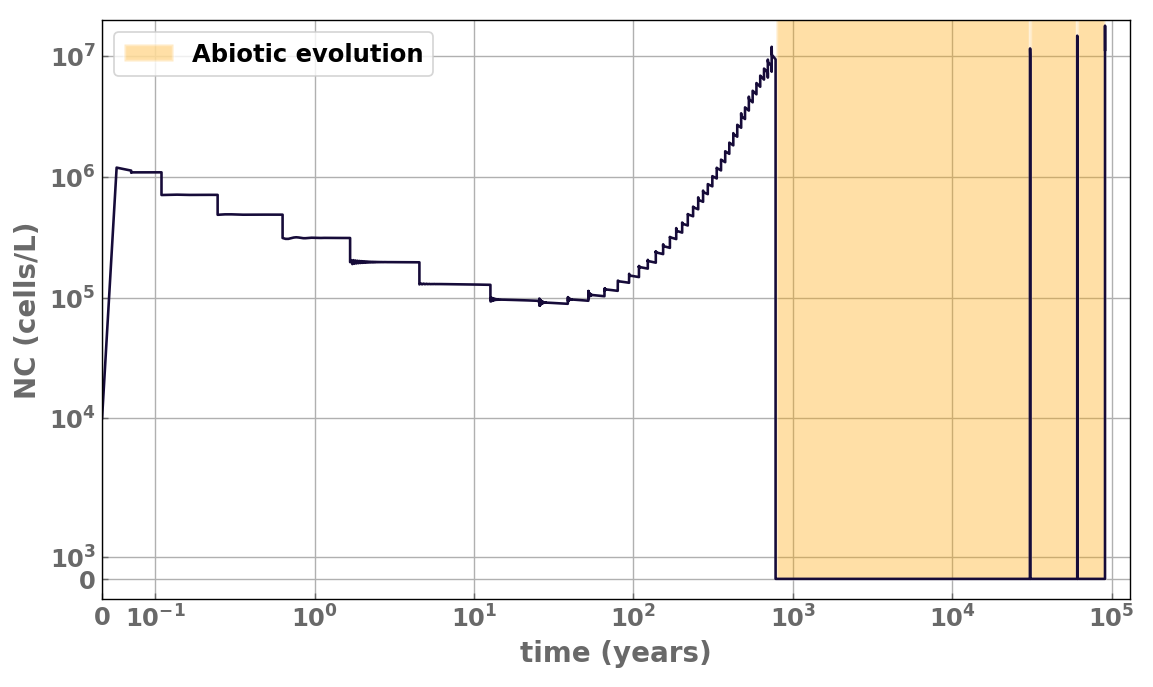

In [85]:
fig, ax = plt.subplots(1, 1)

for m in range(len(tabiobegin_list)):
    x1 = tabiobegin_list[m] / 365.25
    x2 = tabioend_list[m] / 365.25
    y1 = 0
    y2 = 1e50
    plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='orange', alpha=0.35,edgecolor='white',linewidth=2,
            label='Abiotic evolution' if m == 0 else None)

ax.plot(t_list_years , LIST_NC)

ax.legend(fontsize=14, frameon=True)
for text in ax.get_legend().get_texts():
    text.set_weight('bold')
ax.set_ylabel(f'NC (cells/L)', fontsize=16, weight='bold')
ax.set_xlabel("time (years)", fontsize=16, weight='bold')
ax.set_yscale('symlog',linthresh=6e3,linscale=1)

ax.set_ylim(-9E2,2e7)
ax.set_xlim(0,130e3)
ax.set_xscale('symlog',linthresh=1e-1,linscale=0.3)

fig.set_figheight(5)
fig.set_figwidth(8)
fig.tight_layout()
ax.tick_params(labelsize=14)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_weight('bold')
plt.savefig("001_1D_NC.png",dpi=300,bbox_inches='tight')